In [1]:
import pandas as pd
import pytz
import joblib

print('Success')

Success


In [2]:
data0 = pd.read_csv('data/dataset/database_gas.csv')
data1 = pd.read_csv('data/dataset/database_pos.csv')
data2 = pd.read_csv('data/dataset/data_ref_until_2020-02-13.csv')

### Введем вместо столбцов MOX1 - MOX4 столбец MOX_average, в котором будем хранить среднее этих четырёх показателей,а их удалим

In [3]:
data0['MOX_average'] = data0[['MOX1', 'MOX2', 'MOX3', 'MOX4']].mean(axis=1)
data0 = data0.drop(columns=['MOX1', 'MOX2', 'MOX3', 'MOX4'])

data0

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,COValue,MOX_average
0,2019-11-06 11:37:13.038174+01:00,19.48,54.86,128.0,563.0,128.0,605.25
1,2019-11-06 11:37:32.744996+01:00,19.59,54.23,129.0,563.0,125.0,605.50
2,2019-11-06 11:37:53.018087+01:00,19.63,54.05,128.0,566.0,125.0,606.00
3,2019-11-06 11:38:13.093151+01:00,19.64,53.74,128.0,566.0,125.0,606.00
4,2019-11-06 11:38:33.032832+01:00,19.67,53.53,128.0,569.0,125.0,606.75
...,...,...,...,...,...,...,...
416148,2020-02-13 11:56:53.929978+01:00,20.62,57.75,62.0,518.0,157.0,613.75
416149,2020-02-13 11:57:14.204458+01:00,20.62,57.75,62.0,518.0,157.0,613.50
416150,2020-02-13 11:57:33.983249+01:00,20.62,57.75,62.0,518.0,157.0,613.50
416151,2020-02-13 11:57:54.058349+01:00,20.62,57.74,63.0,518.0,157.0,613.50


### Вместо 5 логических столбцов комнат введём один столбец, который будет хранить в себе информацию о комнате, в которой было замечено движение. Также переименуем временной столбец для последующего объединения

In [4]:
data1.rename(columns={'datetime': 'timestamp'}, inplace=True)

def get_person_room(row):
    room_columns = ['Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway']
    for room in room_columns:
        if row[room] == 1:
            return room
    return None  # Если нет движения ни в одной комнате

data1['PersonRoom'] = data1.apply(get_person_room, axis=1)
data1 = data1.dropna(subset=['PersonRoom'])

# data1

Удалим теперь уже избыточные столбцы и захэшируем значение комнаты цифрой

In [5]:
data1 = data1.drop(columns=['Living room', 'Bedroom', 'Bathroom',
                            'Kitchen', 'Hallway'])
data1 = data1.reset_index(drop=True)

change_to_int = {'Living room': 0,
                 'Bedroom': 1,
                 'Bathroom': 2,
                 'Kitchen': 3,
                 'Hallway': 4}

data1['PersonRoom'] = data1['PersonRoom'].replace(change_to_int)

data1

,timestamp,PersonRoom
0,2019-11-01 03:19:57.417067700+00:00,1
1,2019-11-01 05:11:08.874031+00:00,1
2,2019-11-01 05:14:15.993041400+00:00,1
3,2019-11-01 05:19:56.796071400+00:00,1
4,2019-11-01 06:42:17.866021800+00:00,1
...,...,...
14198,2020-02-13 16:58:24.463017900+00:00,2
14199,2020-02-13 16:59:15.305081300+00:00,4
14200,2020-02-13 17:04:37.133057100+00:00,4
14201,2020-02-13 17:04:38.956087800+00:00,0


### Также перейдем от MOX1 - MOX4 к MOX_average

In [6]:
data2['MOX_average'] = data2[['MOX1', 'MOX2', 'MOX3', 'MOX4']].mean(axis=1)
data2 = data2.drop(columns=['MOX1', 'MOX2', 'MOX3', 'MOX4'])

data2

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,COValue,MOX_average
0,2020-01-25 00:01:49.251503+01:00,20.64,55.57,121.0,496.0,135.0,614.50
1,2020-01-25 00:02:09.350082+01:00,20.64,55.53,122.0,495.0,135.0,614.50
2,2020-01-25 00:02:29.319505+01:00,20.62,55.53,121.0,495.0,135.0,614.50
3,2020-01-25 00:02:49.399379+01:00,20.62,55.57,121.0,495.0,135.0,614.50
4,2020-01-25 00:03:09.158989+01:00,20.62,55.59,121.0,495.0,135.0,614.75
...,...,...,...,...,...,...,...
75506,2020-02-13 11:56:53.929978+01:00,20.62,57.75,62.0,518.0,157.0,613.75
75507,2020-02-13 11:57:14.204458+01:00,20.62,57.75,62.0,518.0,157.0,613.50
75508,2020-02-13 11:57:33.983249+01:00,20.62,57.75,62.0,518.0,157.0,613.50
75509,2020-02-13 11:57:54.058349+01:00,20.62,57.74,63.0,518.0,157.0,613.50


Поменяем тип данных в столбцах на datetime

In [7]:
data0['timestamp'] = pd.to_datetime(data0['timestamp'], utc=True)
data1['timestamp'] = pd.to_datetime(data1['timestamp'], utc=True)
data2['timestamp'] = pd.to_datetime(data2['timestamp'], utc=True)

In [8]:
# new_timezone = pytz.timezone('Europe/Paris')
# data1['timestamp'] = data1['timestamp'].dt.tz_convert(new_timezone)

Округлим значения времени до секунд, чтобы избавиться от избыточной информации и облегчить объединение по времени

In [9]:
data0['timestamp'] = data0['timestamp'].dt.round('S')
data1['timestamp'] = data1['timestamp'].dt.round('S')
data2['timestamp'] = data2['timestamp'].dt.round('S')

### Объединим все 3 таблицы в одну итоговую

In [10]:
merged_data0 = pd.merge(data1, data0, on='timestamp', how='inner')
merged_data1 = pd.merge(data1, data2, on='timestamp', how='inner')

merged_data = pd.concat([merged_data0, merged_data1], ignore_index=True)

merged_data

,timestamp,PersonRoom,temperature,humidity,CO2CosIRValue,CO2MG811Value,COValue,MOX_average
0,2019-11-06 12:20:33+00:00,4,19.76,51.37,87.0,615.0,96.0,649.25
1,2019-11-06 13:13:33+00:00,3,20.55,50.28,87.0,614.0,106.0,608.00
2,2019-11-06 18:43:07+00:00,0,24.03,49.35,109.0,603.0,121.0,618.50
3,2019-11-06 20:18:06+00:00,3,24.60,48.38,119.0,596.0,150.0,592.00
4,2019-11-07 11:33:46+00:00,2,18.77,53.97,78.0,615.0,119.0,667.00
...,...,...,...,...,...,...,...,...
714,2020-02-10 16:05:40+00:00,2,21.10,55.54,63.0,517.0,91.0,650.50
715,2020-02-10 17:09:01+00:00,2,21.12,56.80,78.0,513.0,93.0,645.50
716,2020-02-10 17:50:01+00:00,4,21.09,57.09,90.0,511.0,94.0,644.00
717,2020-02-10 17:57:40+00:00,0,21.06,57.26,90.0,511.0,94.0,643.75


Итоговый датасет получен, теперь можно приступать к обучению

## Обучение модели 

### 1. Логистическая регрессия

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

print('Success')

Success


In [12]:
X = merged_data[['temperature', 'humidity']]#, 'MOX_average', 'CO2CosIRValue', 'CO2MG811Value', 'COValue']]
y = merged_data['PersonRoom']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [14]:
model = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=42, max_iter=100000))
model.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=100000, random_state=42))])

In [16]:
joblib.dump(model, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

In [17]:
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.17989664082687337


In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[20  0  0  0  2]
 [11  0  0  0  1]
 [14  0  0  0  1]
 [ 4  0  0  0  2]
 [15  0  0  0  2]]


Результат удручает, но это все из-за проблемы с данными, при улучшенном EDA результат был бы выше

### Случайные леса

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

print('Success')

Success


In [20]:
X = merged_data[['temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value', 'COValue', 'MOX_average']]
y = merged_data['PersonRoom']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [24]:
y_pred = model.predict(X_test)

In [25]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.49      0.44        45
           1       0.35      0.35      0.35        17
           2       0.43      0.36      0.39        33
           3       0.50      0.20      0.29        10
           4       0.36      0.36      0.36        39

    accuracy                           0.39       144
   macro avg       0.41      0.35      0.37       144
weighted avg       0.39      0.39      0.39       144



In [26]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[22  4  5  2 12]
 [ 7  6  0  0  4]
 [13  2 12  0  6]
 [ 1  0  4  2  3]
 [13  5  7  0 14]]


Результаты уже гораздо более приятные, модель не выбирает всегда только один класс, но до хороших результатов еще очень далеко

In [27]:
# ! pip install catboost

### Бустинг (используем CatBoost)

In [28]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

print('Success')

Success


In [29]:
X = merged_data[['temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value', 'COValue', 'MOX_average']]
y = merged_data['PersonRoom']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='MultiClass', random_seed=42)
model.fit(X_train, y_train, cat_features=[])

In [33]:
model.save_model('catboost_model.bin')


In [34]:
y_pred = model.predict(X_test)

In [35]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.49      0.45        45
           1       0.41      0.41      0.41        17
           2       0.44      0.36      0.40        33
           3       0.25      0.20      0.22        10
           4       0.38      0.38      0.38        39

    accuracy                           0.40       144
   macro avg       0.38      0.37      0.37       144
weighted avg       0.40      0.40      0.40       144



In [36]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[22  3  5  3 12]
 [ 5  7  1  1  3]
 [ 9  3 12  2  7]
 [ 2  0  3  2  3]
 [14  4  6  0 15]]


Метрики почти не отличаются от случайных лесов, но будем считать эту модель самой лучшей и самой дорогой в биллинг-сервисе!

Далее просто приведены некоторые графики по итоговому датасету, которые помогали в работе

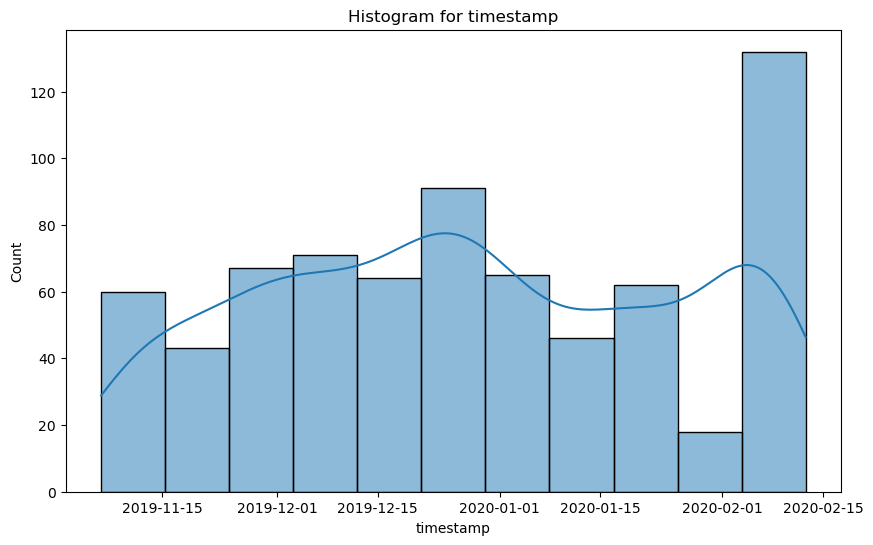

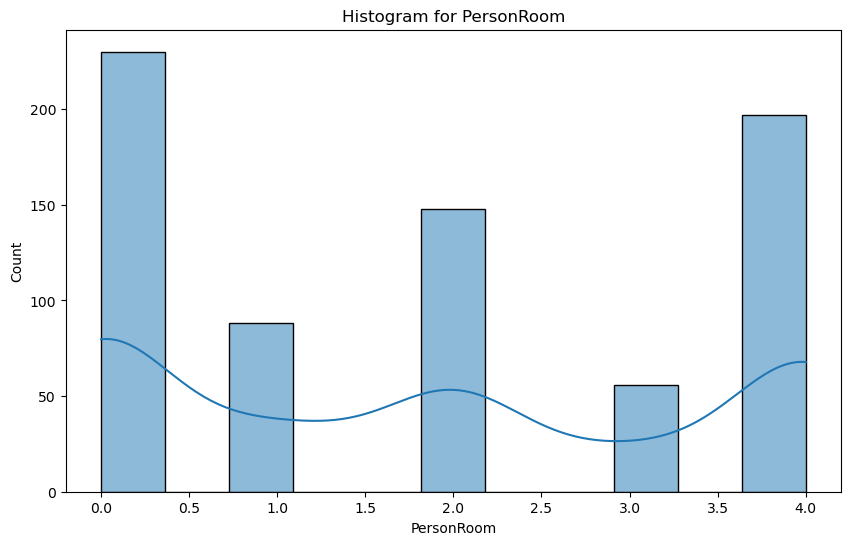

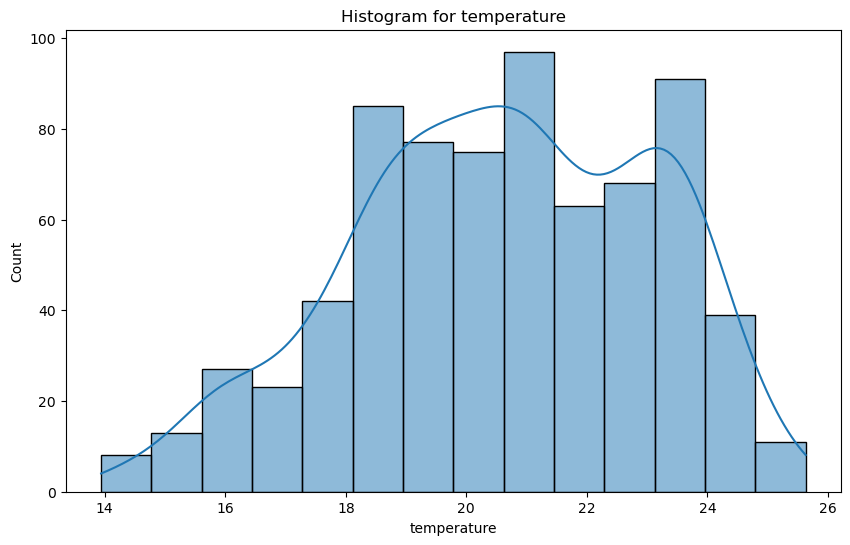

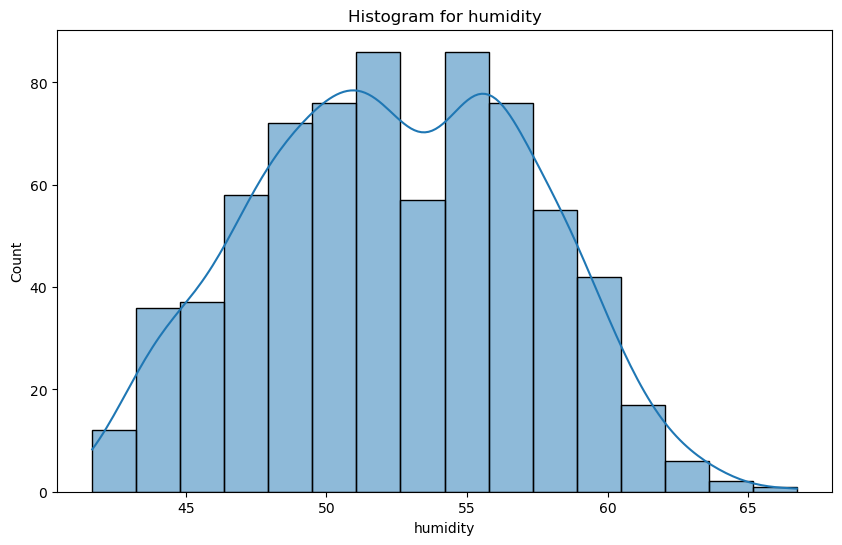

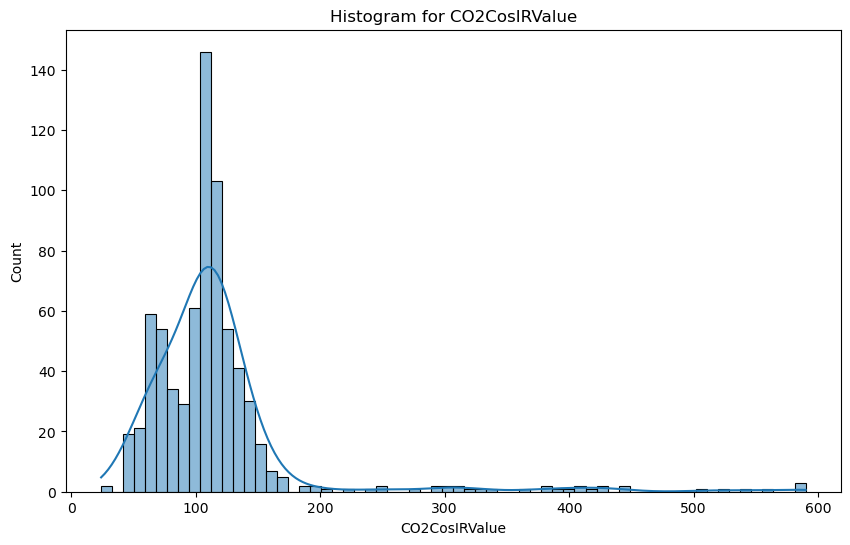

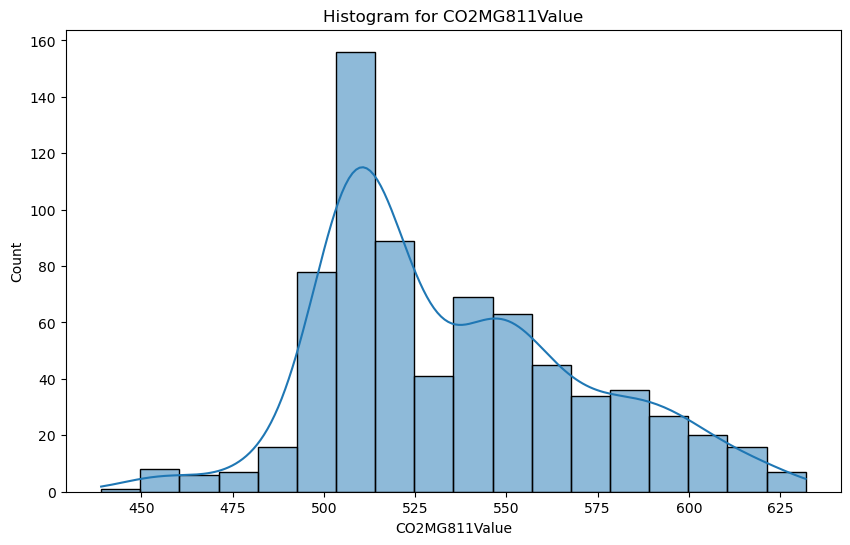

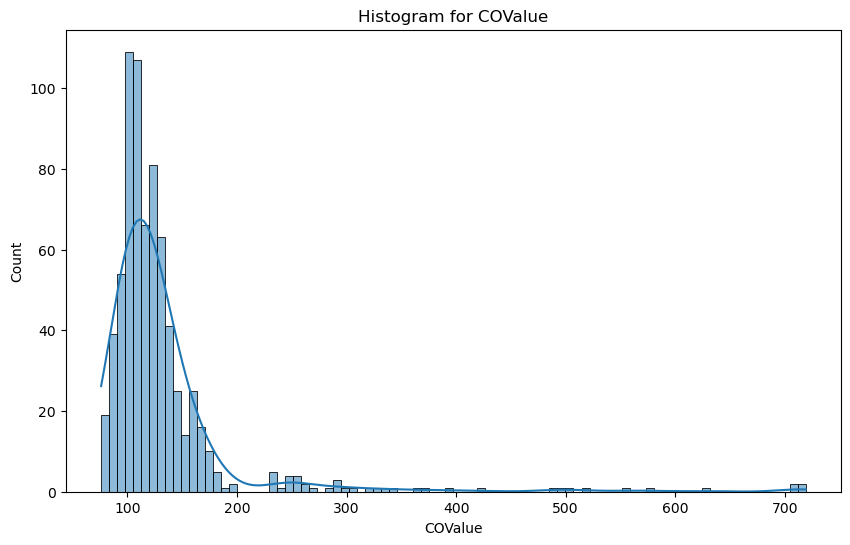

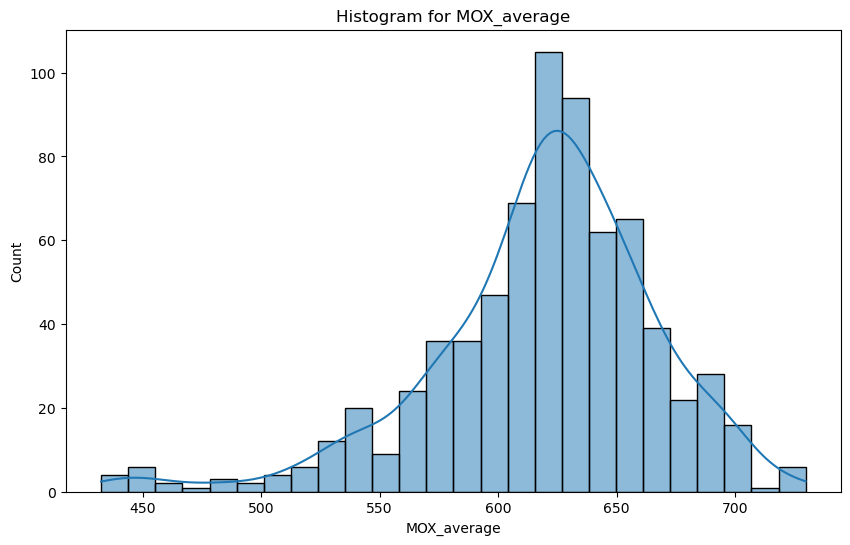

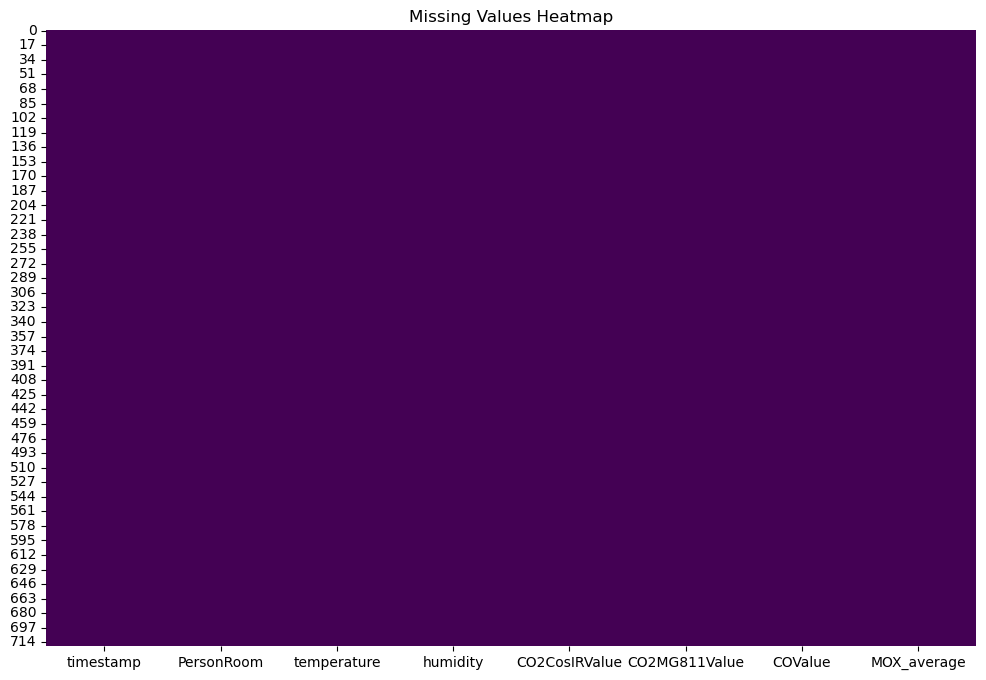

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

for column in merged_data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_data[column].dropna(), kde=True)
    plt.title(f'Histogram for {column}')
    plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(merged_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()